In [1]:
import os
os.listdir('/kaggle/input')
embeddings_path = "/kaggle/input/embeddings"
print(os.listdir(embeddings_path))

['speeches_with_embeddings.csv', 'news_with_embeddings.csv']


# Similarity algorithm efficiently 

In [2]:
import pandas as pd

speeches_embeddings = pd.read_csv(f"{embeddings_path}/speeches_with_embeddings.csv")
news_embeddings = pd.read_csv(f"{embeddings_path}/news_with_embeddings.csv")

# Display first few rows
print("News Data:")
print(news_embeddings.head())

print("\nSpeeches Data:")
print(speeches_embeddings.head())

News Data:
          Index                                               Link  \
0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                              Domain  \
0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1  Expansión Política\nAMLO rinde protesta y prom...   
2  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3  Expansión Política\nAMLO es un "líder persiste...   
4  El Economista\nNicolás Maduro llega a Palacio ...   

                                               Title        Date  \
0  Toma de protesta de AMLO: las 5 tradiciones qu...  2018-12-01   
1        AMLO rinde protesta y promete no reelegirse  2018-12-01   
2  ¿Hay Ley Seca este 1 de 

In [3]:
print(news_embeddings.shape) 
print(news_embeddings.columns)
print(speeches_embeddings.columns)

(42822, 10)
Index(['Index', 'Link', 'Domain', 'Title', 'Date', 'Content', 'month_abbr',
       'processed_content', 'news_chunks', 'news_embeddings'],
      dtype='object')
Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'speech_chunks', 'speech_embeddings'],
      dtype='object')


In [4]:
# Step 1: Sort speeches by the date
speeches_embeddings = speeches_embeddings.sort_values(by='date', ascending=True)

# Step 2: Reset the index so that we can modify it
speeches_embeddings = speeches_embeddings.reset_index(drop=True)

# Step 3: Format the date into dd_mm_yyyy
speeches_embeddings['date_formatted'] = pd.to_datetime(speeches_embeddings['date']).dt.strftime('%d_%m_%Y')

# Step 4: Update the existing index with the new format (speech_number_dd_mm_yyyy)
speeches_embeddings.index = (speeches_embeddings.index + 1).astype(str) + '_' + speeches_embeddings['date_formatted']

# Step 5: Check the resulting DataFrame
print(speeches_embeddings[['date', 'speech_id']].head())



                    date  speech_id
1_04_12_2018  2018-12-04      18410
2_04_12_2018  2018-12-04      18410
3_04_12_2018  2018-12-04      18410
4_04_12_2018  2018-12-04      18410
5_04_12_2018  2018-12-04      18410


In [5]:
print(speeches_embeddings.columns)
print(speeches_embeddings.head())

Index(['Unnamed: 0', 'X', 'speech_id', 'title', 'urls', 'content', 'date',
       'speech_chunks', 'speech_embeddings', 'date_formatted'],
      dtype='object')
              Unnamed: 0     X  speech_id  \
1_04_12_2018        2113  2113      18410   
2_04_12_2018        2113  2113      18410   
3_04_12_2018        2113  2113      18410   
4_04_12_2018        2113  2113      18410   
5_04_12_2018        2113  2113      18410   

                                                          title  \
1_04_12_2018  Conferencia de prensa del presidente de México...   
2_04_12_2018  Conferencia de prensa del presidente de México...   
3_04_12_2018  Conferencia de prensa del presidente de México...   
4_04_12_2018  Conferencia de prensa del presidente de México...   
5_04_12_2018  Conferencia de prensa del presidente de México...   

                                                           urls  \
1_04_12_2018  https://lopezobrador.org.mx/2018/12/04/confere...   
2_04_12_2018  https://lopezobra

### Idea: do PCA for embeddings so I have around 90% of information in three dimensions instead of 768. 

In [6]:
print(type(news_embeddings['news_embeddings'].iloc[0]))
#since it is a class 'str' then we need to convert the embedding as a numpy array
# Convert 'date' column to datetime if it is not already in datetime format
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'], errors='coerce')
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'], errors='coerce')

# Subset the data to 2019 and reset indices

news_2019_reset = news_embeddings[news_embeddings['Date'].dt.year == 2019].reset_index(drop=True)
speeches_2019_reset = speeches_embeddings[speeches_embeddings['date'].dt.year == 2019].reset_index(drop=True)


<class 'str'>


In [7]:
# Add indices to both news and speech embeddings
news_2019_reset['news_index'] = news_2019_reset.index
speeches_2019_reset['speech_index'] = speeches_2019_reset.index


In [8]:
import numpy as np

# Function to clean and convert the embeddings with indices
def clean_and_convert_with_index(embedding_str, index):
    cleaned_str = embedding_str.replace('[', '').replace(']', '').replace('\n', '')
    embedding = np.array(cleaned_str.split()).astype(float)
    return np.append(embedding, index)  # Append index to embedding

In [9]:
import torch 

# Step 2: Clean and convert the embeddings for 2019 data
# Apply cleaning function and include index
cleaned_news_embeddings_2019 = [
    clean_and_convert_with_index(embedding_str, idx) 
    for embedding_str, idx in zip(news_2019_reset['news_embeddings'], news_2019_reset['news_index'])
]

cleaned_speech_embeddings_2019 = [
    clean_and_convert_with_index(embedding_str, idx) 
    for embedding_str, idx in zip(speeches_2019_reset['speech_embeddings'], speeches_2019_reset['speech_index'])
]

# Verify the cleaned embeddings
print("Cleaned news embedding (first sample) for 2019:", cleaned_news_embeddings_2019[0][:10])
print("Cleaned speech embedding (first sample) for 2019:", cleaned_speech_embeddings_2019[0][:10])


Cleaned news embedding (first sample) for 2019: [ 0.07005456  0.1598677   0.18203363 -0.11090291 -0.16807105  0.78287256
  1.24405897  0.93569004 -0.8792305   0.16990131]
Cleaned speech embedding (first sample) for 2019: [-0.72826749 -0.12458038  0.04132178 -0.16114226 -0.30300254  0.11076003
  0.35522407  0.29671001 -0.21902293  0.14100061]


In [10]:
import torch
import numpy as np

# Convert cleaned embeddings to NumPy arrays
news_matrix_2019 = np.vstack(cleaned_news_embeddings_2019)
speech_matrix_2019 = np.vstack(cleaned_speech_embeddings_2019)

# Convert NumPy arrays to PyTorch tensors and move to GPU
# Convert NumPy arrays to PyTorch tensors
news_tensor_2019 = torch.tensor(news_matrix_2019, dtype=torch.float32).cuda()
speech_tensor_2019 = torch.tensor(speech_matrix_2019, dtype=torch.float32).cuda()



In [11]:
# Check the tensors
print("News Tensor (first row with index):", news_tensor_2019[0][:10])
print("Speech Tensor (first row with index):", speech_tensor_2019[0][:10])


News Tensor (first row with index): tensor([ 0.0701,  0.1599,  0.1820, -0.1109, -0.1681,  0.7829,  1.2441,  0.9357,
        -0.8792,  0.1699], device='cuda:0')
Speech Tensor (first row with index): tensor([-0.7283, -0.1246,  0.0413, -0.1611, -0.3030,  0.1108,  0.3552,  0.2967,
        -0.2190,  0.1410], device='cuda:0')


In [12]:
# Function to append index to tensor, ensuring the same device
# Function to append string-based index to tensor, ensuring the same device
def append_index_to_tensor(embeddings, indices, device):
    # The embeddings tensor and the string indices are kept separate
    embeddings_with_index = embeddings  # Keep embeddings unchanged
    return embeddings_with_index, indices


In [13]:
news_2019_reset['formatted_news_index'] = news_2019_reset['news_index'].apply(lambda x: f"{x:02d}_{news_2019_reset['Date'].iloc[x-1].day:02d}_{news_2019_reset['Date'].iloc[x-1].month:02d}_{news_2019_reset['Date'].iloc[x-1].year}")
speeches_2019_reset['formatted_speech_index'] = speeches_2019_reset['speech_index'].apply(lambda x: f"{x:02d}_{speeches_2019_reset['date'].iloc[x-1].day:02d}_{speeches_2019_reset['date'].iloc[x-1].month:02d}_{speeches_2019_reset['date'].iloc[x-1].year}")

# Apply the function to both tensors (embeddings as tensors, indices as strings)
news_tensor_with_index_2019, news_indices_2019 = append_index_to_tensor(news_tensor_2019, news_2019_reset['formatted_news_index'], device=news_tensor_2019.device)
speech_tensor_with_index_2019, speech_indices_2019 = append_index_to_tensor(speech_tensor_2019, speeches_2019_reset['formatted_speech_index'], device=speech_tensor_2019.device)

In [14]:
# Verify the shape of the embeddings and check the first few values
print("Shape of news tensor with index:", news_tensor_with_index_2019.shape)
print("Shape of speech tensor with index:", speech_tensor_with_index_2019.shape)

# Print the first 10 values (embedding part) for each tensor
print("First 10 values of news tensor:", news_tensor_with_index_2019[0, :10].cpu().numpy())
print("First 10 values of speech tensor:", speech_tensor_with_index_2019[0, :10].cpu().numpy())

# For debugging: verify the first index value
print("First index (formatted) of news tensor:", news_indices_2019.iloc[0])  # First index string for news tensor
print("First index (formatted) of speech tensor:", speech_indices_2019.iloc[0])  # First index string for speech tensor

Shape of news tensor with index: torch.Size([3275, 769])
Shape of speech tensor with index: torch.Size([32874, 769])
First 10 values of news tensor: [ 0.07005456  0.1598677   0.18203363 -0.11090291 -0.16807105  0.78287256
  1.244059    0.93569005 -0.8792305   0.16990131]
First 10 values of speech tensor: [-0.7282675  -0.12458038  0.04132178 -0.16114226 -0.30300254  0.11076003
  0.35522407  0.29671    -0.21902293  0.14100061]
First index (formatted) of news tensor: 00_31_12_2019
First index (formatted) of speech tensor: 00_27_12_2019


# Code to calculate cosine similarity and tries to solve the ram issue efficiently. 

In [15]:
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory (if not already saved)
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')
speech_tensor_2019 = torch.load('/kaggle/working/speech_tensor_2019.pt')

# Step 3: Define the chunked computation for cosine similarity
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 50  # Adjust batch size as needed
num_speeches = len(speech_tensor_2019)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

# Step 5: Use indices for tracking the news and speech tensors
for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_2019.pt')[batch_start:batch_end].cuda()
    
    similarities_2019 = []
    
    for idx, speech_embedding_2019 in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
        
        # Store results with the indices
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_2019.append({
                'speech_index': speech_indices_2019[batch_start + idx],  # Use the speech index
                'news_index': news_indices_2019[news_id],  # Use the news index
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk with the indices included
    similarities_df_2019 = pd.DataFrame(similarities_2019)
    similarities_df_2019.to_parquet(f'/kaggle/working/similarities_2019_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


<ipython-input-15-efcf1e8296fd>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')
<ipython-input-15-efcf

Finished computing cosine similarities.


In [16]:
import pandas as pd
import glob
import matplotlib.pyplot as plt 
# Step 1: Load all parquet files and combine them into one DataFrame
file_paths = glob.glob('/kaggle/working/similarities_2019_batch_*.parquet')
similarities_df_2019 = pd.concat([pd.read_parquet(f) for f in file_paths], ignore_index=True)

# Check the data after loading
print(similarities_df_2019.head())

      speech_index     news_index  cosine_similarity
0  4650_21_02_2019  00_31_12_2019           0.000087
1  4650_21_02_2019  01_01_01_2019           0.062091
2  4650_21_02_2019  02_01_01_2019           0.168410
3  4650_21_02_2019  03_01_01_2019           0.188442
4  4650_21_02_2019  04_01_01_2019           0.241247


In [17]:
#align similarities

# Assuming similarities_df_2019 already contains the 'speech_index' and 'news_index'

import pandas as pd

# Assuming similarities_df_2019 already contains 'speech_index', 'news_index', and 'cosine_similarity'

# Step 1: Extract date from speech_index and news_index while handling the day-first warning
similarities_df_2019['speech_date'] = pd.to_datetime(similarities_df_2019['speech_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]), dayfirst=True)
similarities_df_2019['news_date'] = pd.to_datetime(similarities_df_2019['news_index'].apply(lambda x: x.split('_')[1] + '-' + x.split('_')[2] + '-' + x.split('_')[3]), dayfirst=True)

# Step 2: Retain the speech_date, news_date, cosine_similarity, and both indexes without aggregation
# No need to group here, just keep them all in the DataFrame
print(similarities_df_2019.head())

      speech_index     news_index  cosine_similarity speech_date  news_date
0  4650_21_02_2019  00_31_12_2019           0.000087  2019-02-21 2019-12-31
1  4650_21_02_2019  01_01_01_2019           0.062091  2019-02-21 2019-01-01
2  4650_21_02_2019  02_01_01_2019           0.168410  2019-02-21 2019-01-01
3  4650_21_02_2019  03_01_01_2019           0.188442  2019-02-21 2019-01-01
4  4650_21_02_2019  04_01_01_2019           0.241247  2019-02-21 2019-01-01


In [18]:
# Group by speech_date and news_date, then aggregate cosine_similarity (e.g., mean or max)
grouped_similarities = similarities_df_2019.groupby(['speech_date', 'news_date'])['cosine_similarity'].agg(['mean', 'max', 'count']).reset_index()

# Rename columns for clarity
grouped_similarities.rename(columns={'mean': 'avg_cosine_similarity', 'max': 'max_cosine_similarity', 'count': 'num_pairs'}, inplace=True)

# Check the result
print(grouped_similarities.head())


  speech_date  news_date  avg_cosine_similarity  max_cosine_similarity  \
0  2019-01-02 2019-01-01               0.371950               0.645141   
1  2019-01-02 2019-01-02               0.797207               0.974935   
2  2019-01-02 2019-01-03               0.855703               0.979670   
3  2019-01-02 2019-01-04               0.857959               0.979745   
4  2019-01-02 2019-01-05               0.861190               0.982327   

   num_pairs  
0        630  
1       2142  
2        504  
3        630  
4        567  


In [19]:
# Filter speeches that occurred on or before the news date
filtered_df = similarities_df_2019[similarities_df_2019['speech_date'] <= similarities_df_2019['news_date']]

# Sort by news_date and speech_date for easier visualization
filtered_df = filtered_df.sort_values(['news_date', 'speech_date']).reset_index(drop=True)
# Group by news_date, but keep all columns and concatenate the results
grouped_df = (
    filtered_df.groupby('news_date')
    .apply(lambda x: x.reset_index(drop=True))
    .reset_index(drop=True)
)

# Display the result
print(grouped_df.head(10))



<ipython-input-19-555175f75806>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.reset_index(drop=True))


    speech_index     news_index  cosine_similarity speech_date  news_date
0  50_02_01_2019  11_02_01_2019           0.673997  2019-01-02 2019-01-02
1  50_02_01_2019  12_02_01_2019           0.704209  2019-01-02 2019-01-02
2  50_02_01_2019  13_02_01_2019           0.731011  2019-01-02 2019-01-02
3  50_02_01_2019  14_02_01_2019           0.754777  2019-01-02 2019-01-02
4  50_02_01_2019  15_02_01_2019           0.775860  2019-01-02 2019-01-02
5  50_02_01_2019  16_02_01_2019           0.794579  2019-01-02 2019-01-02
6  50_02_01_2019  17_02_01_2019           0.811219  2019-01-02 2019-01-02
7  50_02_01_2019  18_02_01_2019           0.826037  2019-01-02 2019-01-02
8  50_02_01_2019  19_02_01_2019           0.839254  2019-01-02 2019-01-02
9  50_02_01_2019  20_02_01_2019           0.851068  2019-01-02 2019-01-02


In [24]:
# Summary statistics grouped by news_date
summary_stats = (
    filtered_df.groupby('news_date')
    .agg(avg_cosine_similarity=('cosine_similarity', 'mean'),
         max_cosine_similarity=('cosine_similarity', 'max'),
         min_cosine_similarity=('cosine_similarity', 'min'),
         num_pairs=('cosine_similarity', 'count'))
    .reset_index()
)
print(summary_stats.head())


   news_date  avg_cosine_similarity  max_cosine_similarity  \
0 2019-01-02               0.797207               0.974935   
1 2019-01-03               0.924123               0.982977   
2 2019-01-04               0.946826               0.986340   
3 2019-01-05               0.956415               0.989369   
4 2019-01-06               0.957843               0.990501   

   min_cosine_similarity  num_pairs  
0               0.100578       2142  
1               0.104544       1248  
2               0.104523       2560  
3               0.123630       2484  
4               0.104150       1782  


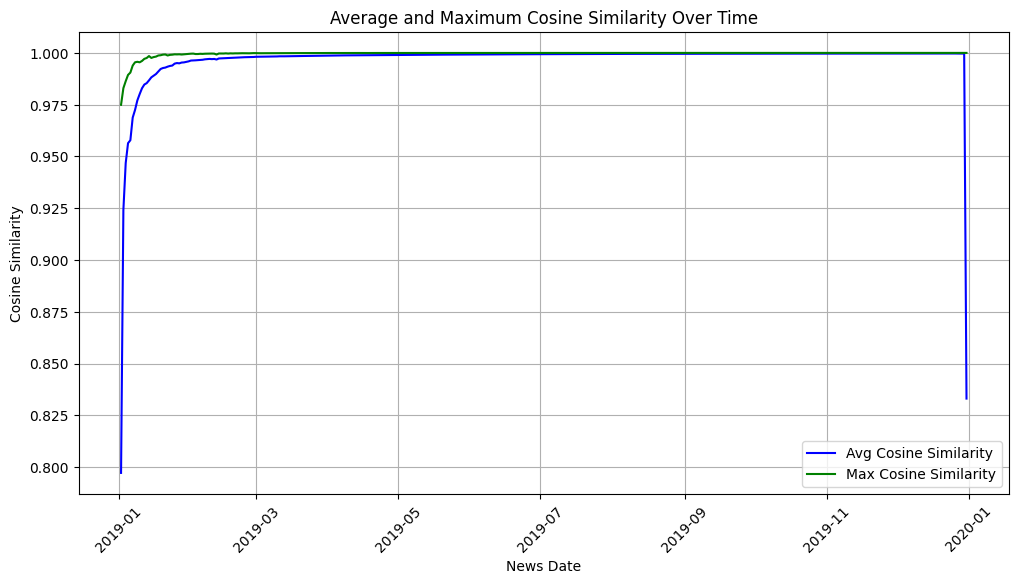

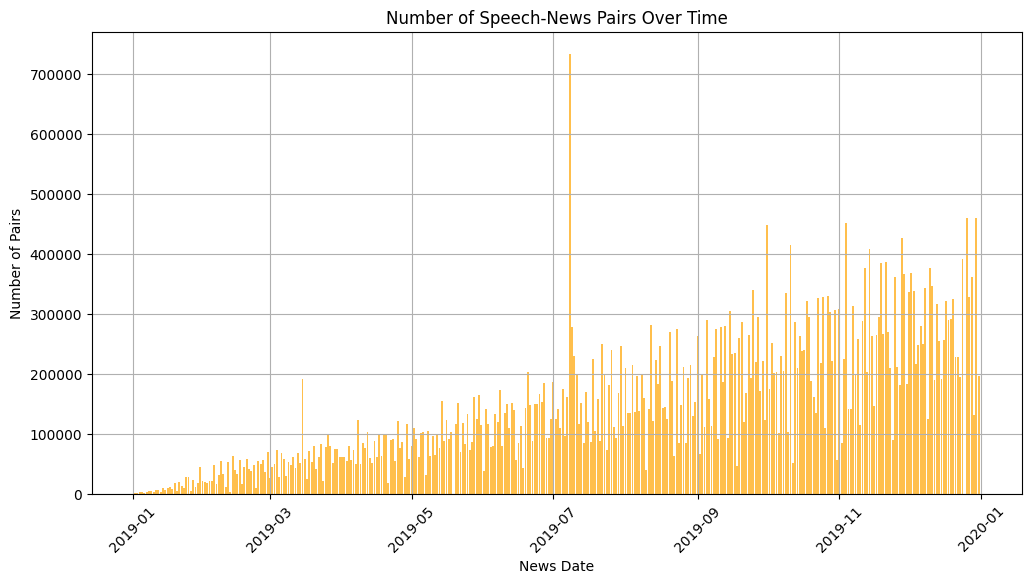

In [22]:
import matplotlib.pyplot as plt

# Convert 'news_date' to datetime if it isn't already
summary_stats['news_date'] = pd.to_datetime(summary_stats['news_date'])

# Plot avg_cosine_similarity over time
plt.figure(figsize=(12, 6))
plt.plot(summary_stats['news_date'], summary_stats['avg_cosine_similarity'], label='Avg Cosine Similarity', color='b')
plt.plot(summary_stats['news_date'], summary_stats['max_cosine_similarity'], label='Max Cosine Similarity', color='g')
plt.xlabel('News Date')
plt.ylabel('Cosine Similarity')
plt.title('Average and Maximum Cosine Similarity Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot num_pairs over time
plt.figure(figsize=(12, 6))
plt.bar(summary_stats['news_date'], summary_stats['num_pairs'], color='orange', alpha=0.7)
plt.xlabel('News Date')
plt.ylabel('Number of Pairs')
plt.title('Number of Speech-News Pairs Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### this function worked when I didnt have the information for the indices for each tensor. 
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk in CPU memory
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load news tensor once, but keep it on the CPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt')

# Step 3: Define the chunked computation
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)
    return torch.mm(batch_embeddings, embedding.T).squeeze()

def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i + chunk_size].cuda()  # Load only the chunk onto GPU
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
        del chunk  # Free memory
        torch.cuda.empty_cache()
    return similarities

# Step 4: Process the speech tensor in batches and save intermediate results
batch_size = 50  # Adjust batch size as needed
num_speeches = len(speech_tensor_2019)
start_time = time.time()
processed_batches = 0  # Counter for batches processed

for batch_start in range(0, num_speeches, batch_size):
    batch_end = min(batch_start + batch_size, num_speeches)

    # Load a batch of speech embeddings to the GPU
    speech_batch = torch.load('/kaggle/working/speech_tensor_2019.pt')[batch_start:batch_end].cuda()
    
    similarities_2019 = []
    
    for idx, speech_embedding_2019 in enumerate(speech_batch):
        cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
        
        # Store results
        for news_id, sim_value in enumerate(cosine_similarities):
            similarities_2019.append({
                'speech_id': batch_start + idx,
                'news_id': news_id,
                'cosine_similarity': sim_value
            })

    # Save intermediate results to disk
    similarities_df_2019 = pd.DataFrame(similarities_2019)
    similarities_df_2019.to_parquet(f'/kaggle/working/similarities_2019_batch_{batch_start}.parquet')
    
    # Free up GPU memory
    del speech_batch
    torch.cuda.empty_cache()
    
    # Increment and check if 1000 batches processed
    processed_batches += 1
    if processed_batches % 1000 == 0:
        elapsed_time = time.time() - start_time
        print(f"Processed {processed_batches * batch_size}/{num_speeches} speeches. Elapsed time: {elapsed_time:.2f}s")

print("Finished computing cosine similarities.")


## Save and visualize results 

In [10]:
import pandas as pd
import glob

# Load all parquet files and combine them into one DataFrame
file_paths = glob.glob('/kaggle/working/similarities_2019_batch_*.parquet')
similarities_df_2019 = pd.concat([pd.read_parquet(f) for f in file_paths], ignore_index=True)

print(similarities_df_2019.head())


   speech_id  news_id  cosine_similarity
0      17500        0           0.103873
1      17500        1           0.103873
2      17500        2           0.306392
3      17500        3           0.306709
4      17500        4           0.103873


In [11]:
print(similarities_df_2019.shape)

(107662350, 3)


In [12]:
# Group by news_id and find the maximum similarity for each news article
max_similarities = similarities_df_2019.groupby('news_id')['cosine_similarity'].max().reset_index()

# Rename the column for clarity
max_similarities.rename(columns={'cosine_similarity': 'max_cosine_similarity'}, inplace=True)

# Check the result
print(max_similarities.head())


   news_id  max_cosine_similarity
0        0               0.213240
1        1               0.213240
2        2               0.405216
3        3               0.383229
4        4               0.213240


In [13]:
# Reset the index of news_embeddings to prepare for merging
news_embeddings_reset = news_embeddings.reset_index()

# Merge max_similarities with news_embeddings on the news_id (which corresponds to the DataFrame index)
news_with_similarity = news_embeddings_reset.merge(max_similarities, left_index=True, right_on='news_id', how='left')

# Check the merged DataFrame
print(news_with_similarity.head())


     index         Index                                               Link  \
0.0      0  1_01_12_2018  https://www.bbc.com/mundo/noticias-america-lat...   
1.0      1  2_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
2.0      2  3_01_12_2018  https://oem.com.mx/elsoldemexico/mexico/en-don...   
3.0      3  4_01_12_2018  https://politica.expansion.mx/presidencia/2018...   
4.0      4  5_01_12_2018  https://www.eleconomista.com.mx/politica/Nicol...   

                                                Domain  \
0.0  BBC\nToma de protesta de AMLO: las 5 tradicion...   
1.0  Expansión Política\nAMLO rinde protesta y prom...   
2.0  El Sol de México\n¿Hay Ley Seca este 1 de dici...   
3.0  Expansión Política\nAMLO es un "líder persiste...   
4.0  El Economista\nNicolás Maduro llega a Palacio ...   

                                                 Title       Date  \
0.0  Toma de protesta de AMLO: las 5 tradiciones qu... 2018-12-01   
1.0        AMLO rinde protesta y prome

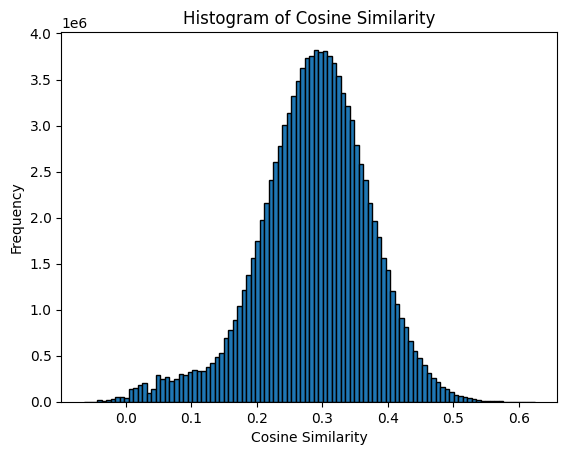

In [21]:
import matplotlib.pyplot as plt

plt.hist(similarities_df_2019['cosine_similarity'], bins=100, edgecolor='k')
plt.title('Histogram of Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


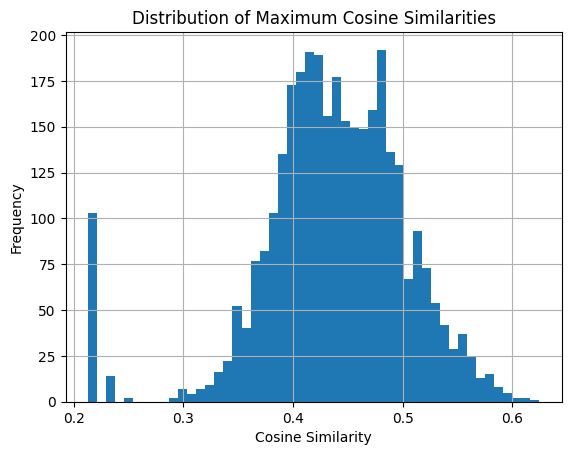

In [19]:
import matplotlib.pyplot as plt
news_with_similarity['max_cosine_similarity'].hist(bins=50)
plt.title('Distribution of Maximum Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()


### RN the main aim is to capture highly similar chunks of obrador's speeches with media articles 

In [23]:
# Filter high-similarity pairs (cosine similarity > 0.5)
high_similarity_pairs = news_with_similarity[news_with_similarity['max_cosine_similarity'] > 0.5]

# Merge with speech metadata to get speech dates (if it's not already part of the DataFrame)
speech_metadata = pd.DataFrame({'speech_id': range(len(news_embeddings)), 'date': pd.date_range('2019-01-01', periods=len(news_embeddings))})
high_similarity_pairs = high_similarity_pairs.merge(speech_metadata, on='speech_id', how='left')

# Ensure 'date' columns are datetime
high_similarity_pairs['speech_date'] = pd.to_datetime(high_similarity_pairs['date'])
high_similarity_pairs['news_date'] = pd.to_datetime(high_similarity_pairs['Date'])  # Assuming 'Date' exists in news metadata

# Calculate time differences
high_similarity_pairs['time_diff_days'] = (high_similarity_pairs['news_date'] - high_similarity_pairs['speech_date']).dt.days

# Check the filtered DataFrame
print(high_similarity_pairs.head())



/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


KeyError: 'speech_id'

## Explore  temporal dependencies 

In [15]:
news_with_similarity['Date'] = pd.to_datetime(news_with_similarity['Date'])
speeches_2019_reset['date'] = pd.to_datetime(speeches_2019_reset['date'])


In [16]:
print(type(news_embeddings['news_embeddings'].iloc[0]))
#since it is a class 'str' then we need to convert the embedding as a numpy array
# Convert 'date' column to datetime if it is not already in datetime format
speeches_embeddings['date'] = pd.to_datetime(speeches_embeddings['date'], errors='coerce')
news_embeddings['Date'] = pd.to_datetime(news_embeddings['Date'], errors='coerce')


<class 'str'>



# Code that works but eats all ram 

In [9]:
import torch
import pandas as pd
import time

# Step 1: Save tensors to disk before loading them
torch.save(news_tensor_2019.cpu(), '/kaggle/working/news_tensor_2019.pt')
torch.save(speech_tensor_2019.cpu(), '/kaggle/working/speech_tensor_2019.pt')

# Step 2: Load tensors from disk and move them to GPU
news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt').cuda()
speech_tensor_2019 = torch.load('/kaggle/working/speech_tensor_2019.pt').cuda()

# Step 3: Compute cosine similarity in chunks
def compute_batch_cosine_similarity(embedding, batch_embeddings):
    # Ensure embedding is 2D (batch_size, embedding_size)
    embedding = embedding.unsqueeze(0) if embedding.dim() == 1 else embedding
    batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=1, keepdim=True)  # Normalize batch

    # Normalize the embedding (1xembedding_size)
    embedding = embedding / embedding.norm(dim=1, keepdim=True)  # Normalize single embedding
    return torch.mm(batch_embeddings, embedding.T).squeeze()  # Cosine similarity


def compute_similarities_in_chunks(speech_tensor, news_tensor, chunk_size=1000):
    similarities = []
    for i in range(0, len(news_tensor), chunk_size):
        chunk = news_tensor[i:i+chunk_size]
        cosine_sim = compute_batch_cosine_similarity(speech_tensor, chunk)
        similarities.extend(cosine_sim.cpu().tolist())
    return similarities

# Step 4: Process the tensor in chunks
similarities_2019 = []
start_time = time.time()

for idx, speech_embedding_2019 in enumerate(speech_tensor_2019):
    cosine_similarities = compute_similarities_in_chunks(speech_embedding_2019, news_tensor_2019)
    
    # Store results
    for news_id, sim_value in enumerate(cosine_similarities):
        similarities_2019.append({
            'speech_id': idx,
            'news_id': news_id,
            'cosine_similarity': sim_value
        })
        
    # Print progress
    if idx % 1000 == 0:
        elapsed_time = time.time() - start_time
        remaining_time = (elapsed_time / (idx + 1)) * (len(speech_tensor_2019) - (idx + 1))
        print(f"Processed {idx + 1}/{len(speech_tensor_2019)} speeches. ETA: {remaining_time:.2f}s")

# Step 5: Save results to disk
similarities_df_2019 = pd.DataFrame(similarities_2019)
similarities_df_2019.to_parquet('/kaggle/working/similarities_2019.parquet')

print("Finished computing cosine similarities.")

<ipython-input-9-dc3944fe2d4e>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  news_tensor_2019 = torch.load('/kaggle/working/news_tensor_2019.pt').cuda()
<ipython-input-9

Processed 1/32874 speeches. ETA: 7517.82s
Processed 1001/32874 speeches. ETA: 80.51s
Processed 2001/32874 speeches. ETA: 72.74s
Processed 3001/32874 speeches. ETA: 68.85s
Processed 4001/32874 speeches. ETA: 66.00s
Processed 5001/32874 speeches. ETA: 63.75s
Processed 6001/32874 speeches. ETA: 61.26s
Processed 7001/32874 speeches. ETA: 58.68s
Processed 8001/32874 speeches. ETA: 56.24s
Processed 9001/32874 speeches. ETA: 53.92s
Processed 10001/32874 speeches. ETA: 51.50s
Processed 11001/32874 speeches. ETA: 49.15s
Processed 12001/32874 speeches. ETA: 46.86s
Processed 13001/32874 speeches. ETA: 44.60s
Processed 14001/32874 speeches. ETA: 42.30s
Processed 15001/32874 speeches. ETA: 40.02s
Processed 16001/32874 speeches. ETA: 37.76s
Processed 17001/32874 speeches. ETA: 35.51s
Processed 18001/32874 speeches. ETA: 33.28s
Processed 19001/32874 speeches. ETA: 31.10s
Processed 20001/32874 speeches. ETA: 28.84s
Processed 21001/32874 speeches. ETA: 26.58s
Processed 22001/32874 speeches. ETA: 24.34s

KeyboardInterrupt: 